In [1]:
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import resnet50
from timeit import default_timer as timer
from torch.autograd import Variable
%matplotlib inline

In [2]:
# Image transformations
image_transforms = {
    # Train uses data augmentation (not implemented)
    'train':
    transforms.Compose([
        transforms.Resize((64,64)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    
    'validate':
    transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # Test set does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
#keep the images as PIL so they can be transformed later
def image_arrs(da_path, da_arr):
    for path in da_path:
        image = cv2.imread(path)
        image_from_array = Image.fromarray(image, 'RGB')
        da_arr.append(image_from_array)
    return da_arr

In [4]:
#Training Data
df_train = pd.read_csv('Train.csv')
paths1 = df_train[(df_train['ClassId'] ==1)]['Path'].values
paths2 = df_train[(df_train['ClassId'] ==2)]['Path'].values
paths3 = df_train[(df_train['ClassId'] ==3)]['Path'].values

#Testing Data
df_test = pd.read_csv('Test.csv')
paths1_test = df_test[(df_test['ClassId'] ==1)]['Path'].values
paths2_test = df_test[(df_test['ClassId'] ==2)]['Path'].values
paths3_test = df_test[(df_test['ClassId'] ==3)]['Path'].values

In [5]:
#get image arrays

#Training
class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

class3_arrs = []
class3_arrs = image_arrs(paths3, class3_arrs)

#Testing
class1_arrs_test = []
class1_arrs_test = image_arrs(paths1_test, class1_arrs_test)

class2_arrs_test = []
class2_arrs_test = image_arrs(paths2_test, class2_arrs_test)

class3_arrs_test = []
class3_arrs_test = image_arrs(paths3_test, class3_arrs_test)

In [6]:
#set up training/validation sets
# 80% to train, 20% to validation
print(len(class1_arrs)*0.8, len(class2_arrs)*0.8, len(class3_arrs)*0.8)

X_train = class1_arrs[:1776] + class2_arrs[:1800] + class3_arrs[:1128]
X_val = class1_arrs[1776:] + class2_arrs[1800:] + class3_arrs[1128:]

y_train = (1776*[0]) + (1800*[1]) + (1128*[2])
y_val = (444*[0]) + (450*[1]) + (282*[2])

print("Train length:", len(X_train), len(y_train))
print("Validation length:", len(X_val), len(y_val))

1776.0 1800.0 1128.0
Train length: 4704 4704
Validation length: 1176 1176


In [7]:
#Concat testing sets

X_test = class1_arrs_test + class2_arrs_test + class3_arrs_test
y_test = (len(class1_arrs_test)*[0]) + (len(class2_arrs_test)*[1]) + (len(class3_arrs_test)*[2])

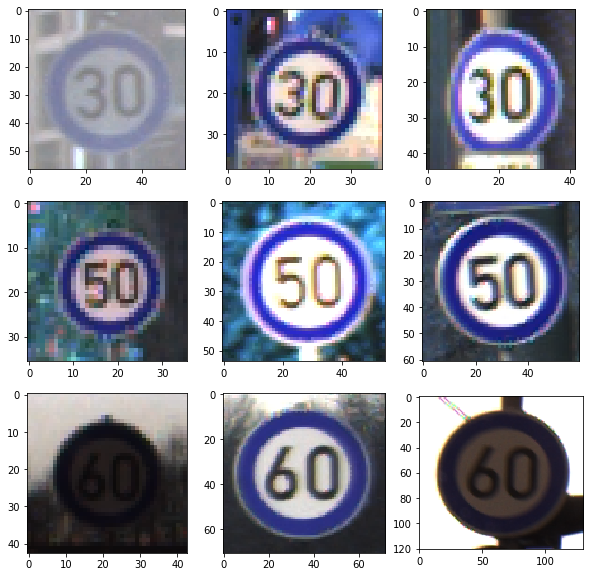

In [8]:
#show images
fig, ax = plt.subplots(3,3, figsize=(10,10))
ax[0][0].imshow(X_train[0])
ax[0][1].imshow(X_val[0])
ax[0][2].imshow(X_test[0])
ax[1][0].imshow(X_train[2540])
ax[1][1].imshow(X_val[450])
ax[1][2].imshow(X_test[1000])
ax[2][0].imshow(X_train[-1])
ax[2][1].imshow(X_val[-1])
ax[2][2].imshow(X_test[-1])

In [9]:
for i in range(len(X_train)):
    X_train[i] = image_transforms['train'](X_train[i])
for i in range(len(X_val)):
    X_val[i] = image_transforms['validate'](X_val[i])
for i in range(len(X_test)):
    X_test[i] = image_transforms['test'](X_test[i])

In [10]:
# convert variables themselves to tensors
X_train = torch.stack(X_train)
X_val = torch.stack(X_val)
X_test = torch.stack(X_test)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


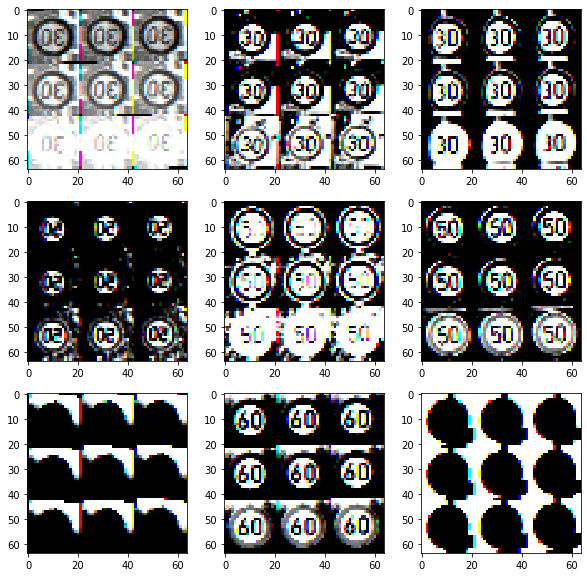

In [11]:
#show images
fig, ax = plt.subplots(3,3, figsize=(10,10))
ax[0][0].imshow(X_train[0].view(64,64,3))
ax[0][1].imshow(X_val[0].view(64,64,3))
ax[0][2].imshow(X_test[0].view(64,64,3))
ax[1][0].imshow(X_train[2540].view(64,64,3))
ax[1][1].imshow(X_val[450].view(64,64,3))
ax[1][2].imshow(X_test[1000].view(64,64,3))
ax[2][0].imshow(X_train[-1].view(64,64,3))
ax[2][1].imshow(X_val[-1].view(64,64,3))
ax[2][2].imshow(X_test[-1].view(64,64,3))

In [12]:
#create training and testing sets
train_data = [(X_train[i], y_train[i]) for i in range(len(X_train))]
val_data = [(X_val[i], y_val[i]) for i in range(len(X_val))]
test_data = [(X_test[i], y_test[i]) for i in range(len(X_test))]
print(len(train_data), len(val_data), len(test_data))

trainset = torch.utils.data.DataLoader(train_data, batch_size=42, shuffle=True)
valset = torch.utils.data.DataLoader(val_data, batch_size=42, shuffle=True)

# are you supposed to put the testset into batches?
testset = torch.utils.data.DataLoader(test_data, batch_size=42, shuffle=True)

# batch size 32 : set size [32,3,64,64]

4704 1176 1920


In [13]:
type(X_train)

torch.Tensor

**CNN**

In [14]:
def output_size(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

output_size(6, 2, 2, 0)

3

In [15]:
# build CNN class

class ConvNet(nn.Module):
        
        def __init__(self):
            super(ConvNet, self).__init__()
            
            # convolutions
            self.conv1 = nn.Conv2d(3, 6, kernel_size=10, padding=2, stride=3)
            self.conv2 = nn.Conv2d(6, 12, kernel_size=5, padding=2, stride=1)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            
            # Linear layers
            self.fc1 = nn.Linear(12*10*10, 100)
            self.fc2 = nn.Linear(100, 32)
            self.fc3 = nn.Linear(32, 3)
        
        # pass through each layer
        def forward(self, x):
            
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)
            
            #print(x.shape)
            
            # change size
            x = x.view(-1, 12*10*10)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            
            return F.log_softmax(x, dim=1)

In [16]:
# initialize net and parameters
net = ConvNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00085)
criterion = nn.CrossEntropyLoss()
EPOCHS = 30

# loss and accuracy 
train_loss = []
val_loss = []
train_acc = []
val_acc = []

print(net)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(10, 10), stride=(3, 3), padding=(2, 2))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [17]:
for epoch in range(EPOCHS):
    
    start = timer()
    
    for data in trainset:
        X,y = data
        
        # set gradient to 0 each time
        net.zero_grad()
        output = net(X)

        loss = criterion(output, y)
        
        # backpropagation
        loss.backward()
        # take a step
        optimizer.step()
    
    # add to our loss array
    train_loss.append(loss)
    
    # compute running accuracies at end of epoch
    
    pred = torch.argmax(net.forward(X_train), axis=1)
    train = torch.sum(pred==y_train).float()/len(pred)
    train_acc.append(train.item())
    
    pred = torch.argmax(net.forward(X_val), axis=1)
    val = torch.sum(pred==y_val).float()/len(pred)
    val_acc.append(val.item())
    
    for X,y in valset:
        pred = net.forward(X)
        
        vals_loss = criterion(pred, y)
    val_loss.append(vals_loss)
    
    
    if epoch%5 == 0:
        print(f'Epoch: {epoch + 1} \t Training Loss: {train_loss[-1]:.3f} \
             \t Validation Loss: {val_loss[-1]:.3f} \t Time Elapsed in Epoch: {timer()-start:.2f}')
 
    
# print final accuracies
print('Training Accuracy:', train_acc[-1])
print('Validation Accuracy:', val_acc[-1])

Epoch: 1 	 Training Loss: 0.806              	 Validation Loss: 1.071 	 Time Elapsed in Epoch: 5.35
Epoch: 6 	 Training Loss: 0.050              	 Validation Loss: 0.219 	 Time Elapsed in Epoch: 4.68
Epoch: 11 	 Training Loss: 0.006              	 Validation Loss: 0.312 	 Time Elapsed in Epoch: 4.60
Epoch: 16 	 Training Loss: 0.003              	 Validation Loss: 0.022 	 Time Elapsed in Epoch: 4.72
Epoch: 21 	 Training Loss: 0.000              	 Validation Loss: 0.120 	 Time Elapsed in Epoch: 4.63
Epoch: 26 	 Training Loss: 0.000              	 Validation Loss: 0.008 	 Time Elapsed in Epoch: 4.56
Training Accuracy: 1.0
Validation Accuracy: 0.956632673740387


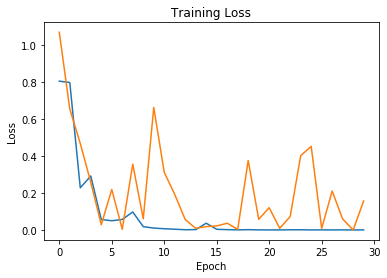

In [18]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

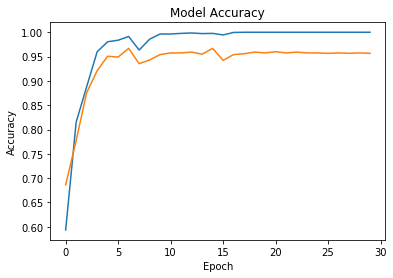

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.956632673740387


In [19]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print("Final Training Accuracy:", train_acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

In [20]:
#for test
correct = 0
total = 0

with torch.no_grad():
    pred = torch.argmax(net.forward(X_test), axis=1)
    test_acc = torch.sum(pred==y_test).float()/len(pred)
    
print(test_acc)

tensor(0.9693)


# three classes got:
    * batch size 32:
        * train acc of 100%
        * val acc of 96.1%
        * test acc of 95.6%
    * batch size 42:
        * train acc 99%
        * val acc 94.6%
        * test acc 96.9%
    * batch size 35:  NOT A FACTOR OF X_TRAIN SIZE
        * train acc 61%
        * val acc 61%
        * test acc 60%